In [1]:
from pybaseball import statcast_pitcher, playerid_lookup
from scipy.stats import beta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

In [2]:
# Apply dark aesthetic
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='dark',
    font='sans-serif',
    font_scale=1.2,  # Slightly larger font
    color_codes=True,
)

# Custom bright palette
custom_palette = [ "#FFD700",
    "#6FC3DF", 
    "#C94C4C",]  # Gold, Blue, Red
sns.set_palette(custom_palette)

# Matplotlib global settings
plt.rcParams.update({
    'axes.facecolor': '#2f2f2f',      # Dark axes background
    'figure.facecolor': '#1f1f1f',    # Dark figure background
    'axes.edgecolor': 'white',        # White axes borders
    'axes.labelcolor': 'white',       # White axis labels
    'xtick.color': 'white',           # White x-ticks
    'ytick.color': 'white',           # White y-ticks
    'text.color': 'white',            # White text (for titles, annotations)
    'grid.color': '#4a4a4a',          # Gray gridlines (softer than white)
    'grid.linestyle': '--',
    'axes.titlesize': 16,             # Title size
    'axes.labelsize': 14,             # Axis label size
})

In [3]:
# calculating league average whiff % 2022-2024
df = pd.read_csv('datasets/stats.csv')
mean_whiff = df['whiff_percent'].mean()
std_whiff_pop = df['whiff_percent'].std(ddof=0)

print("Mean of whiff_percent:", mean_whiff)
print("Population Standard Deviation:", std_whiff_pop)

Mean of whiff_percent: 24.930448717948714
Population Standard Deviation: 3.9529122407748423


In [4]:
# 1. Data Collection from Statcast
def get_swing_data(player_id, start_date, end_date):
    """
    Returns total swings and whiffs for a pitcher
    Args:
        player_id: MLBAM ID
        start_date: YYYY-MM-DD
        end_date: YYYY-MM-DD
    Returns:
        n: total swings
        y: total whiffs
    """
    df = statcast_pitcher(start_date, end_date, player_id)
    
    # Validate data
    if df.empty:
        raise ValueError(f"No data found for player {player_id} from {start_date} to {end_date}")
    # Count swings and whiffs
    is_swing = df['description'].isin(['swinging_strike', 'foul', 'hit_into_play'])
    is_whiff = df['description'] == 'swinging_strike'
    
    return sum(is_swing), sum(is_whiff)

In [5]:
playerid_lookup('veneziano', 'anthony')

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,veneziano,anthony,685107,venea001,venezan01,27453,2023.0,2025.0


In [6]:
# 2. Parameters
player_id = 685107  # Anthony Veneziano's MLB ID
start_date = '2025-03-29'
end_date = '2025-04-07'

In [7]:
# 3. Prior Selection (Using 2022-2023 MLB reliever averages)
prior_mean = 0.24930448717948714  # μ = 23% league average whiff rate
prior_std = 0.039529122407748423   # σ = 3% standard deviation

In [8]:
# Calculate alpha and beta from mean and std
prior_var = prior_std**2
α = prior_mean * (prior_mean*(1-prior_mean)/prior_var - 1)
β = (1-prior_mean) * (prior_mean*(1-prior_mean)/prior_var - 1)

In [9]:
# 4. Get Data
try:
    n, y = get_swing_data(player_id, start_date, end_date)
    print(f"Observed: {y} whiffs in {n} swings ({y/n:.1%})")
except ValueError as e:
    print(e)
    exit()


Gathering Player Data
Observed: 5 whiffs in 26 swings (19.2%)


In [10]:
# 5. Posterior Calculation
α_post = α + y
β_post = β + n - y
posterior_mean = α_post / (α_post + β_post)
posterior_std = np.sqrt((α_post*β_post)/((α_post+β_post)**2*(α_post+β_post+1)))

In [11]:
# 6. Credible Interval
ci_95 = beta.ppf([0.025, 0.975], α_post, β_post)

In [12]:
# 7. Results
print(f"\nBayesian Estimation Results:")
print(f"Prior: Beta(α={α:.1f}, β={β:.1f})")
print(f"Posterior: Beta(α={α_post:.1f}, β={β_post:.1f})")
print(f"Posterior mean: {posterior_mean:.3f}")
print(f"Posterior std: {posterior_std:.3f}")
print(f"95% Credible Interval: [{ci_95[0]:.3f}, {ci_95[1]:.3f}]")



Bayesian Estimation Results:
Prior: Beta(α=29.6, β=89.2)
Posterior: Beta(α=34.6, β=110.2)
Posterior mean: 0.239
Posterior std: 0.035
95% Credible Interval: [0.173, 0.312]


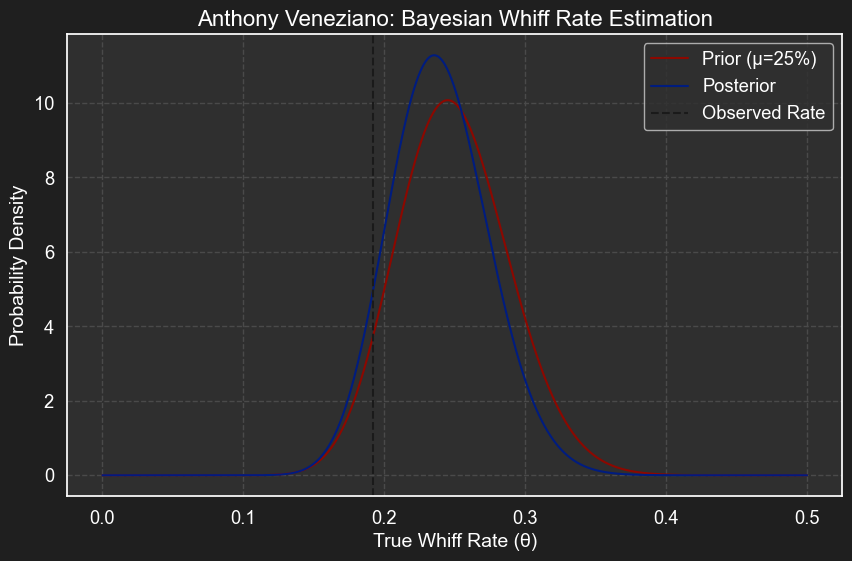

In [21]:
# 8. Visualization
x = np.linspace(0, 0.5, 1000)
plt.figure(figsize=(10, 6))
plt.plot(x, beta.pdf(x, α, β), 'r-', label=f'Prior (μ={prior_mean:.0%})')
plt.plot(x, beta.pdf(x, α_post, β_post), 'b-', label='Posterior')
plt.axvline(y/n, color='k', linestyle='--', label='Observed Rate')
plt.xlabel('True Whiff Rate (θ)')
plt.ylabel('Probability Density')
plt.title('Anthony Veneziano: Bayesian Whiff Rate Estimation')
plt.legend()
plt.grid(True)
plt.savefig("veneziano_plot.png", dpi=300)  # High resolution (300 DPI)
plt.show()


## different model

In [14]:
# 3. Bayesian Model
with pm.Model() as model:
    # Prior (MLB reliever average: 23% ± 3%)
    μ = 0.24930448717948714
    σ = 0.039529122407748423
    α = μ * ((μ*(1-μ)/σ**2) - 1)
    β = (1-μ) * ((μ*(1-μ)/σ**2) - 1)
    θ = pm.Beta('θ', alpha=α, beta=β)
    
    # Likelihood
    y_obs = pm.Binomial('y_obs', n=n, p=θ, observed=y)
    
    # Inference
    trace = pm.sample(2000, tune=1000, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


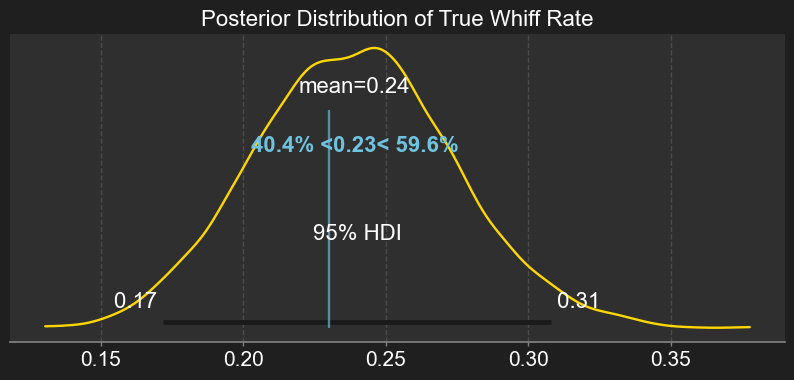

In [22]:
# 4. Arviz Visualization
with az.rc_context(rc={'plot.max_subplots': None}):
    # Posterior Plot
    az.plot_posterior(trace, var_names=['θ'], 
                     hdi_prob=0.95,
                     ref_val=0.23,
                     point_estimate='mean',
                     figsize=(10, 4))
    plt.title('Posterior Distribution of True Whiff Rate')
    plt.savefig("veneziano_arviz.png", dpi=300)  # High resolution (300 DPI)

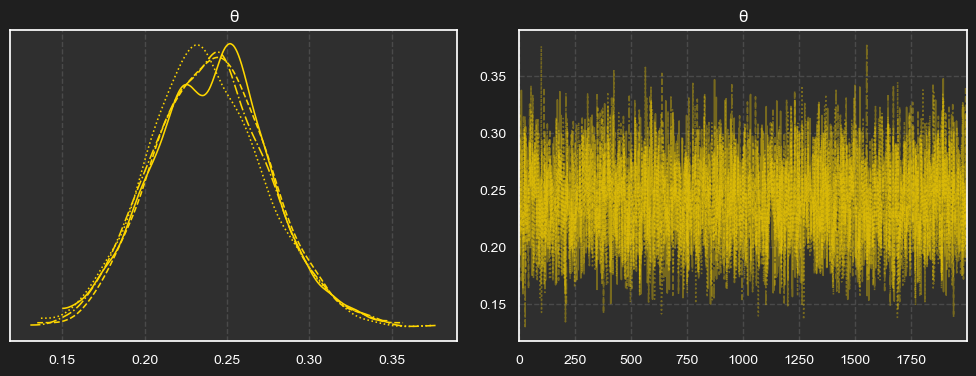

In [23]:
    # Trace Plot
    az.plot_trace(trace, figsize=(10, 4))
    plt.tight_layout()
plt.savefig("veneziano_arviz2.png", dpi=300)  # High resolution (300 DPI)


Bayesian Analysis Results:
-------------------------
1. Bayes Estimate (Posterior Mean): 0.239
2. Posterior Variance: 0.00125
3. 95% Credible Interval: [0.173, 0.312]
4. Large-Sample Approximation: N(μ=0.192, σ²=0.00597)



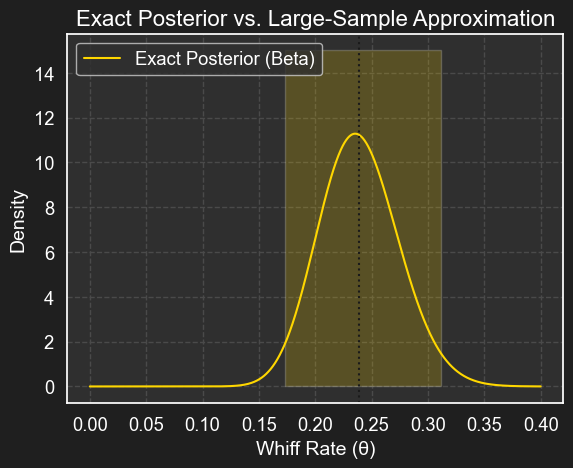

In [24]:
import numpy as np
from scipy.stats import beta, norm
import arviz as az

# Observed data (replace with actual values)
y = 5  # whiffs
n = 26 # total swings


# Posterior parameters
α_post = α + y
β_post = β + n - y

# 1. Bayes Estimate (Posterior Mean)
bayes_estimate = α_post / (α_post + β_post)

# 2. Posterior Variance
posterior_var = (α_post * β_post) / ((α_post + β_post)**2 * (α_post + β_post + 1))

# 3. 95% Credible Interval
ci_low, ci_high = beta.ppf([0.025, 0.975], α_post, β_post)

# 4. Large-Sample Approximation
sample_θ = y/n
sample_var = sample_θ*(1-sample_θ)/n

# Results
print(f"""
Bayesian Analysis Results:
-------------------------
1. Bayes Estimate (Posterior Mean): {bayes_estimate:.3f}
2. Posterior Variance: {posterior_var:.5f}
3. 95% Credible Interval: [{ci_low:.3f}, {ci_high:.3f}]
4. Large-Sample Approximation: N(μ={sample_θ:.3f}, σ²={sample_var:.5f})
""")

# Visualization
import matplotlib.pyplot as plt
x = np.linspace(0, 0.4, 1000)

# Exact posterior
plt.plot(x, beta.pdf(x, α_post, β_post), 
         label='Exact Posterior (Beta)')

# Normal approximation
if n > 100:  # Only valid for large n
    plt.plot(x, norm.pdf(x, sample_θ, np.sqrt(sample_var)),
             label='Normal Approximation',
             linestyle='--')

plt.axvline(bayes_estimate, color='k', linestyle=':')
plt.fill_betweenx([0, 15], ci_low, ci_high, alpha=0.2)
plt.xlabel('Whiff Rate (θ)')
plt.ylabel('Density')
plt.legend()
plt.title('Exact Posterior vs. Large-Sample Approximation')
plt.show()